# Information frictions in the sequence space

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import json
import sequence_jacobian as sj

In [2]:
plt.rcParams.update({'font.size': 10, 'font.family': 'serif', 'figure.figsize': (6, 3)})
plt.rcParams.update({'text.usetex': True, 'font.serif': 'Palatino'})

In [3]:
from household import hh, calibration
hh = hh.remap({'r': 'rp'})
calibration['rp'] = calibration['r']

In [4]:
# Compute steady state
ss = hh.steady_state(calibration)

In [5]:
# time horizon used here
T = 400

## Set up other blocks

Set up fiscal and market clearing blocks.

In [6]:
@sj.solved(unknowns={'B': (-10, 10)}, targets=['budget'])
def fiscal(rp, G, Y, psi, B):
    # B = (1 + rp.ss) * B_ss / (1 + rp(+1))
    T_ss = rp.ss * B.ss + G.ss  # steady state tax
    T = T_ss + psi * ((1 + rp) * B(-1) - (1 + rp.ss) * B.ss) 
    # T = T_ss + psi * (B(-1) - B_ss)  # alternative without interest rate
    budget = B - (1 + rp) * B(-1) + T - G  # budget constraint
    Z = Y - T  # after tax income
    deficit = G - T
    return T, Z, deficit, budget

@sj.simple
def mkt_clearing(A, B, Y, C, G):
    asset_mkt = A - B
    goods_mkt = Y - C - G
    return asset_mkt, goods_mkt

Set up the model and run the steady state.

In [7]:
ha = sj.create_model([fiscal, hh, mkt_clearing], name="Simple HA Model")

In [8]:
calibration.update({'G': 1 - ss['C'],
                    'Y': 1,
                    'psi': 0.1,
                    'B': ss['A']})
ss = ha.steady_state(calibration, dissolve=['fiscal'])

Check

In [9]:
ss['asset_mkt'], ss['goods_mkt'], ss['budget']

(1.1330132824838302e-05, -4.530474770891857e-07, 3.608224830031759e-15)

## Set up functions to make monetary plots

In [10]:
def plot_MP(Mr_list, M_list, filename='test', legend_list=None, color_list=['black','red','blue','brown','orange', 'green'],
            style_list=['solid']*6, rho=0.80, Tplot=70, Tfg=40):

    n = len(Mr_list)
    assert n == len(M_list)
    
    assert n <= 6  # need to add more colors and styles if larger
    
    if legend_list is None:
        legend_list = [''] * n
    else:
        assert len(legend_list) == n
        
    # Shock
    dr = - 0.25 * rho ** np.arange(T)
    drp1, drp2 = np.zeros_like(dr), np.zeros_like(dr)
    drp1[1:] = dr[:-1]
    drp2[Tfg:] = dr[:T-Tfg]

    # Plot
    plt.figure(figsize=(8.3, 4))
    plt.subplot(1,2,1)
    for i in range(n):
        tax_irf = fiscal.impulse_linear(ss, inputs={'rp': drp1})['T']
        irf = np.linalg.solve(np.eye(T) - M_list[i], Mr_list[i] @ drp1 - M_list[i] @ tax_irf)
        plt.plot(irf[:Tplot], color=color_list[i], label=legend_list[i], linestyle=style_list[i])
    plt.axhline(y=0, color='#808080', linestyle=':')
    plt.xlabel('Quarter')
    plt.ylabel('\% of output')
    plt.title('Response to $t=0$ rate cut')
    plt.subplot(1,2,2)
    for i in range(n):
        tax_irf = fiscal.impulse_linear(ss, inputs={'rp': drp2})['T']
        irf = np.linalg.solve(np.eye(T) - M_list[i], Mr_list[i] @ drp2 - M_list[i] @ tax_irf)
        plt.plot(irf[:Tplot], color=color_list[i], label=legend_list[i], linestyle=style_list[i])
    plt.axhline(y=0, color='#808080', linestyle=':')
    plt.xlabel('Quarter')
    plt.title('Response to $t=' + str(Tfg) + '$ rate cut')
    plt.tight_layout()
    plt.legend(frameon=False)
    plt.savefig('figures/lecture13_' + filename + '.pdf', transparent=True)

## FIRE benchmark

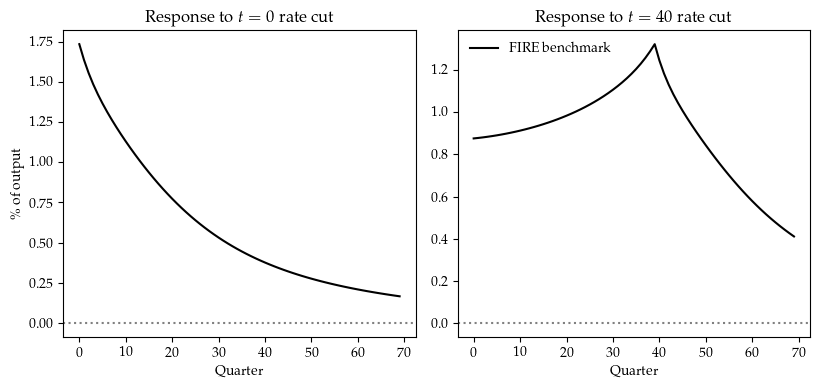

In [11]:
J = hh.jacobian(ss, inputs=['rp', 'Z'], outputs=['C', 'A'], T=T)
M_ha = J['C', 'Z']
Mr_ha = J['C', 'rp']

plot_MP([Mr_ha], [M_ha], filename='fire_benchmark', legend_list=['FIRE benchmark'])

Check this

In [12]:
# irf = ha.solve_impulse_linear(ss, unknowns=['Y'], targets=['goods_mkt'], inputs={'rp': -0.25 * 0.8**np.arange(T)}) 

# Set up Jacobian manipulation functions

This function manipulates a FIRE Jacobian `M` with expectations matrix `E` to give the behavioral Jacobian `M_beh`.

In [13]:
from numba import njit
@njit
def manipulate_separable(M, E):
    """ Here, E is the expectation matrix, M is the FIRE Jacobian """
    T, m = M.shape
    assert T == m
    assert E.shape == (T, T)
    
    M_beh = np.empty_like(M)
    for t in range(T):
        for s in range(T):
            summand = 0
            for tau in range(min(s,t)+1):
                if tau > 0:
                    summand += (E[tau, s] - E[tau-1, s]) * M[t - tau, s - tau]
                else:
                    summand += E[tau, s] * M[t - tau, s - tau]
            M_beh[t, s] = summand
    return M_beh

Test this function.

In [14]:
# test with unit expectations matrix
M = np.random.rand(10, 10)
E = np.ones((10, 10))
manipulate_separable(M, E)
assert np.allclose(manipulate_separable(M, E), M)

# test with upper triangular expectations matrix
M = np.random.rand(10, 10)
E = np.tril(np.ones((10, 10)))
Mbeh = manipulate_separable(M, E)
for i in range(10):
    assert np.allclose(Mbeh[i:, i], M[:10-i, 0])

### Sticky expectations
Ok great, that seems to work well! Let's add functions that compute the specific expectations matrices.

In [15]:
def E_sticky_exp(theta, T=T, sticky_info=False):
    col = 1 - theta**(1 + np.arange(T))
    E = np.tile(col[:, np.newaxis], (1, T))
    if sticky_info:
        return E
    else:
        E = np.triu(E, +1) + np.tril(np.ones((T, T)))
        return E

Simple test:

In [16]:
E_sticky_exp(0.5)[:5, :5]

array([[1.    , 0.5   , 0.5   , 0.5   , 0.5   ],
       [1.    , 1.    , 0.75  , 0.75  , 0.75  ],
       [1.    , 1.    , 1.    , 0.875 , 0.875 ],
       [1.    , 1.    , 1.    , 1.    , 0.9375],
       [1.    , 1.    , 1.    , 1.    , 1.    ]])

### Dispersed information

Great, let's move on to dispersed information. Here, the inputs are the precisions $\tau_j$.

In [17]:
def E_dispersed_exog(taus, T=T, sticky_info=False):
    assert taus.shape == (T,)  # these are tau_j / tau_eps
    col = np.cumsum(taus) / (np.cumsum(taus) + 1)
    E = np.tile(col[:, np.newaxis], (1, T))
    if sticky_info:
        return E
    else:
        E = np.triu(E, +1) + np.tril(np.ones((T, T)))
        return E

In [18]:
E_dispersed_exog(np.ones(T)*1)[:5, :5]

array([[1.        , 0.5       , 0.5       , 0.5       , 0.5       ],
       [1.        , 1.        , 0.66666667, 0.66666667, 0.66666667],
       [1.        , 1.        , 1.        , 0.75      , 0.75      ],
       [1.        , 1.        , 1.        , 1.        , 0.8       ],
       [1.        , 1.        , 1.        , 1.        , 1.        ]])

Looking great again!

### Cognitive discounting

Let's move on to cognitive discounting

In [19]:
def E_cog_disc(theta, T=T):
    E = np.ones((T, T))
    for t in range(T):
        E[t,t:] = theta**np.arange(T-t)
    return E

In [20]:
E_cog_disc(0.5)[:5, :5]

array([[1.    , 0.5   , 0.25  , 0.125 , 0.0625],
       [1.    , 1.    , 0.5   , 0.25  , 0.125 ],
       [1.    , 1.    , 1.    , 0.5   , 0.25  ],
       [1.    , 1.    , 1.    , 1.    , 0.5   ],
       [1.    , 1.    , 1.    , 1.    , 1.    ]])

In [21]:
assert np.allclose(E_cog_disc(0), E_sticky_exp(1))

### Level $k$ thinking

Finally, let's deal with level $k$ thinking.

In [22]:
def level_k(M, k_max=1, T=T):
    # first construct the level k = 1 matrix and solution
    M1 = manipulate_separable(M, E_cog_disc(0, T=T))
    G1 = np.linalg.inv(np.eye(T) - M1)
    
    # now iterate
    G_list = [G1]
    M_list = [M1]
    for i in range(k_max-1):
        G_k = G_list[-1]
        partialY_kplus1 = np.eye(T) + (M - M1) @ G_k
        G_kplus1 =  np.linalg.solve(np.eye(T) - M1, partialY_kplus1)
        M_effective = np.eye(T) - np.linalg.solve(partialY_kplus1, np.eye(T) - M1)
        G_list.append(G_kplus1)
        M_list.append(M_effective)
    M_list.reverse()
    return M_list

# Applying information frictions to monetary policy in HANK

Now all we're going to do is to apply the above Jacobian manipulation functions to the above FIRE Jacobians to obtain the effects of surprise and anticipated monetary policy shocks in HANK models with various information frictions.

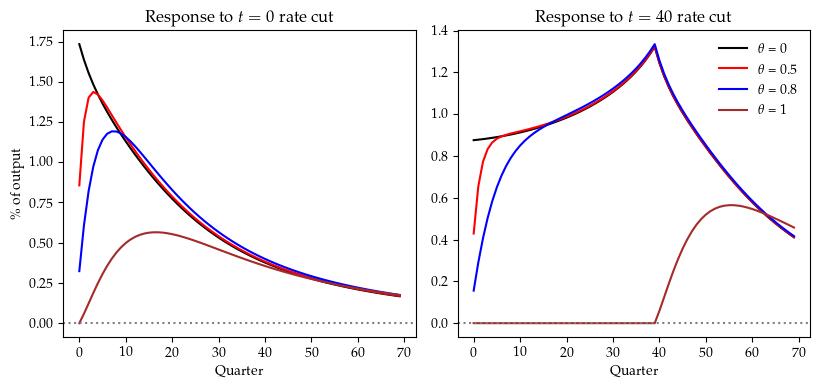

In [23]:
# Sticky expectations
thetas = [0, 0.5, 0.8, 1]
M_list = [manipulate_separable(M_ha, E_sticky_exp(theta)) for theta in thetas]
Mr_list = [manipulate_separable(Mr_ha, E_sticky_exp(theta)) for theta in thetas] #[Mr_ha] * len(M_list)
legend_list = ['$\\theta$ = '+str(theta) for theta in thetas]
plot_MP(Mr_list, M_list, filename='sticky_exp', legend_list=legend_list)

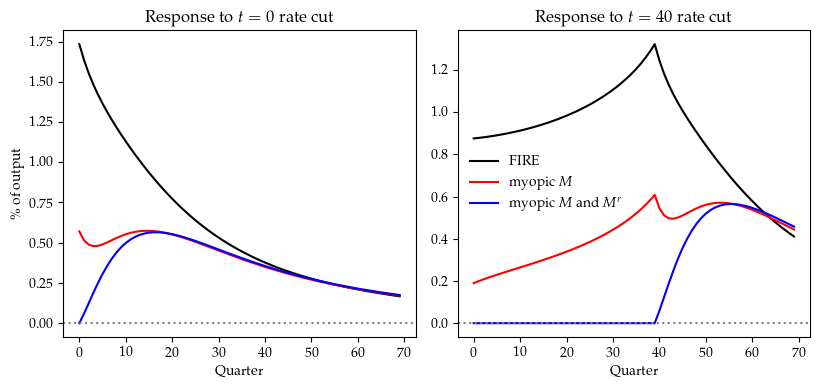

In [24]:
# Full vs no sticky expectations
thetas = [0, 1]
M_list = [manipulate_separable(M_ha, E_sticky_exp(theta)) for theta in thetas + [1]]
Mr_list = [Mr_ha] + [manipulate_separable(Mr_ha, E_sticky_exp(theta)) for theta in thetas] #[Mr_ha] * len(M_list)
legend_list = ['FIRE', 'myopic $M$', 'myopic $M$ and $M^r$']  # ['$\\theta$ = '+str(theta) for theta in thetas]
plot_MP(Mr_list, M_list, filename='full_sticky_exp', legend_list=legend_list)

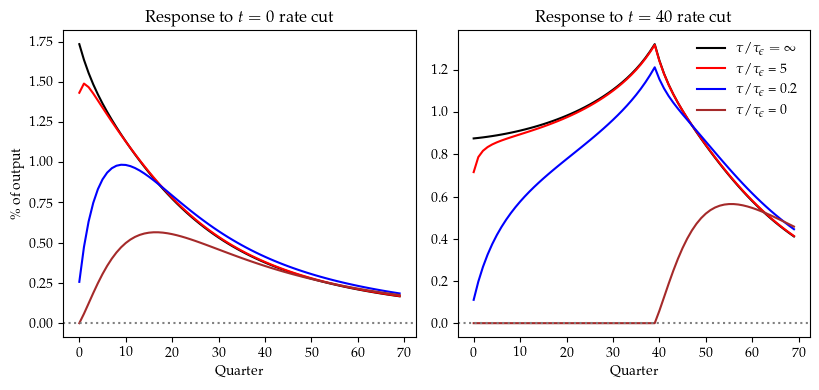

In [25]:
# Dispersed information
taus = [1e10, 5, 0.2, 0]  # constant for all j
M_list = [manipulate_separable(M_ha, E_dispersed_exog(np.ones(T)*tau)) for tau in taus]
Mr_list = [manipulate_separable(Mr_ha, E_dispersed_exog(np.ones(T)*tau)) for tau in taus] #[Mr_ha] * len(M_list)
legend_list = ['$\\tau / \\tau_\\epsilon = \\infty $'] + ['$\\tau / \\tau_\\epsilon $ = '+str(tau) for tau in taus[1:]]
plot_MP(Mr_list, M_list, filename='dispersed_info', legend_list=legend_list)

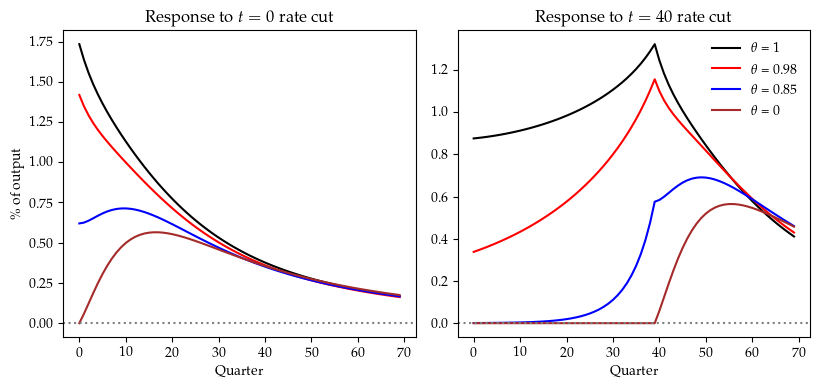

In [26]:
# Cognitive discounting
thetas = [1, 0.98, 0.85, 0]
M_list = [manipulate_separable(M_ha, E_cog_disc(theta)) for theta in thetas]
Mr_list = [manipulate_separable(Mr_ha, E_cog_disc(theta)) for theta in thetas] #[Mr_ha] * len(M_list)
legend_list = ['$\\theta$ = '+str(theta) for theta in thetas]
plot_MP(Mr_list, M_list, filename='cog_disc', legend_list=legend_list)

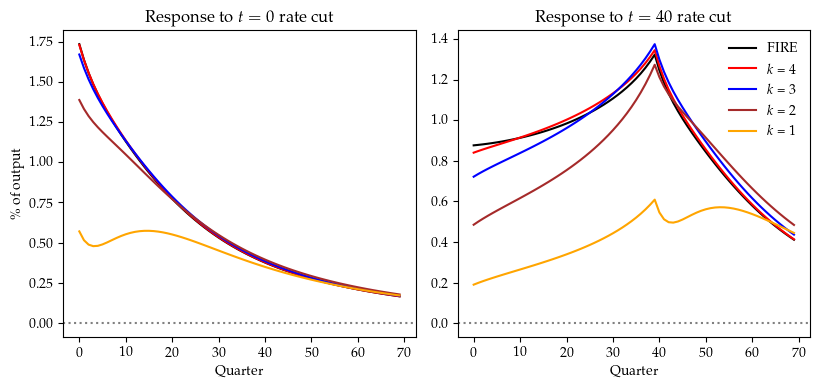

In [27]:
# Level k thinking
k_max = 4
M_list = [M_ha] + level_k(M_ha, k_max=k_max)
Mr_list = [Mr_ha] * len(M_list)
legend_list = ['FIRE'] + ['$k$ = '+str(k) for k in range(k_max, 0, -1)]
plot_MP(Mr_list, M_list, filename='level_k', legend_list=legend_list)